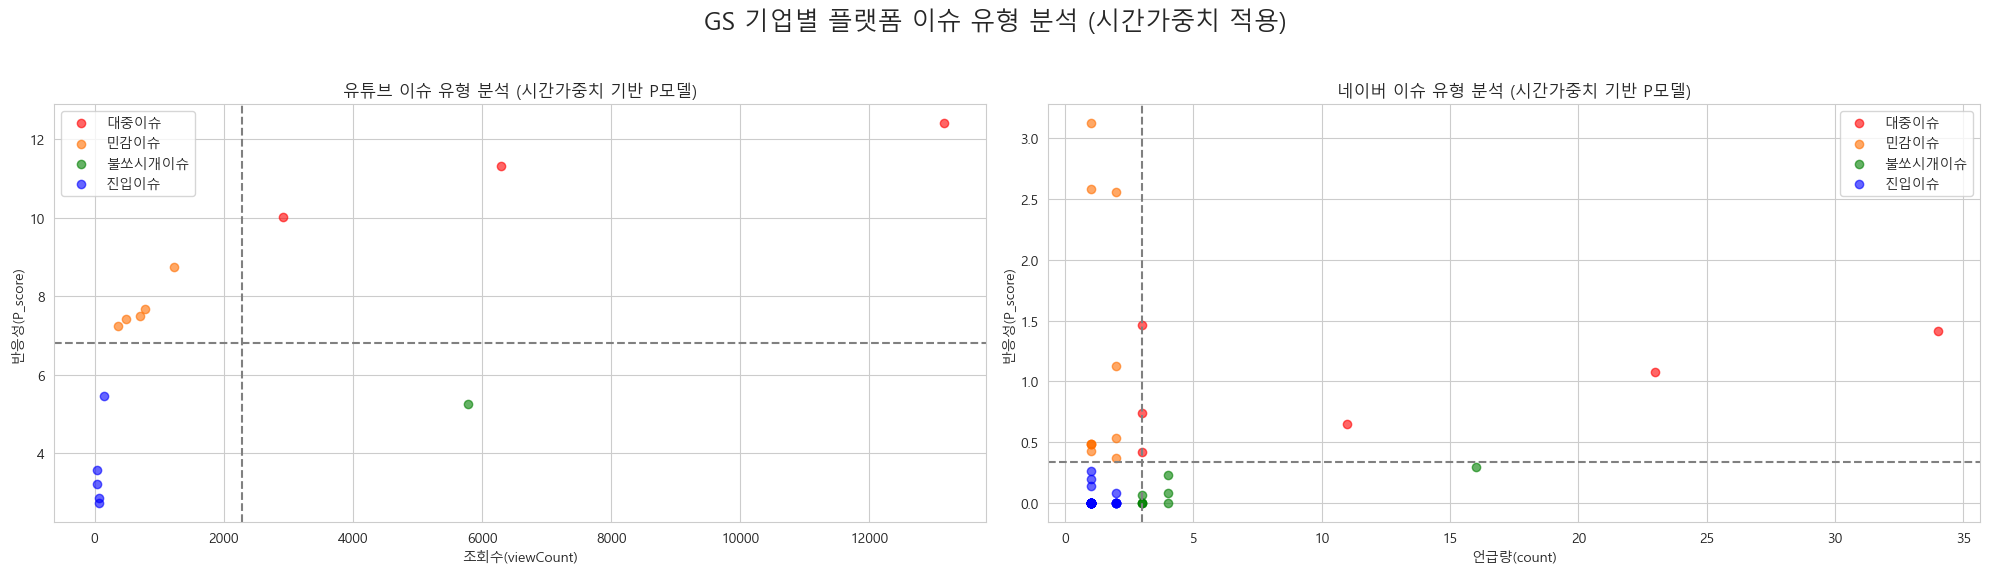

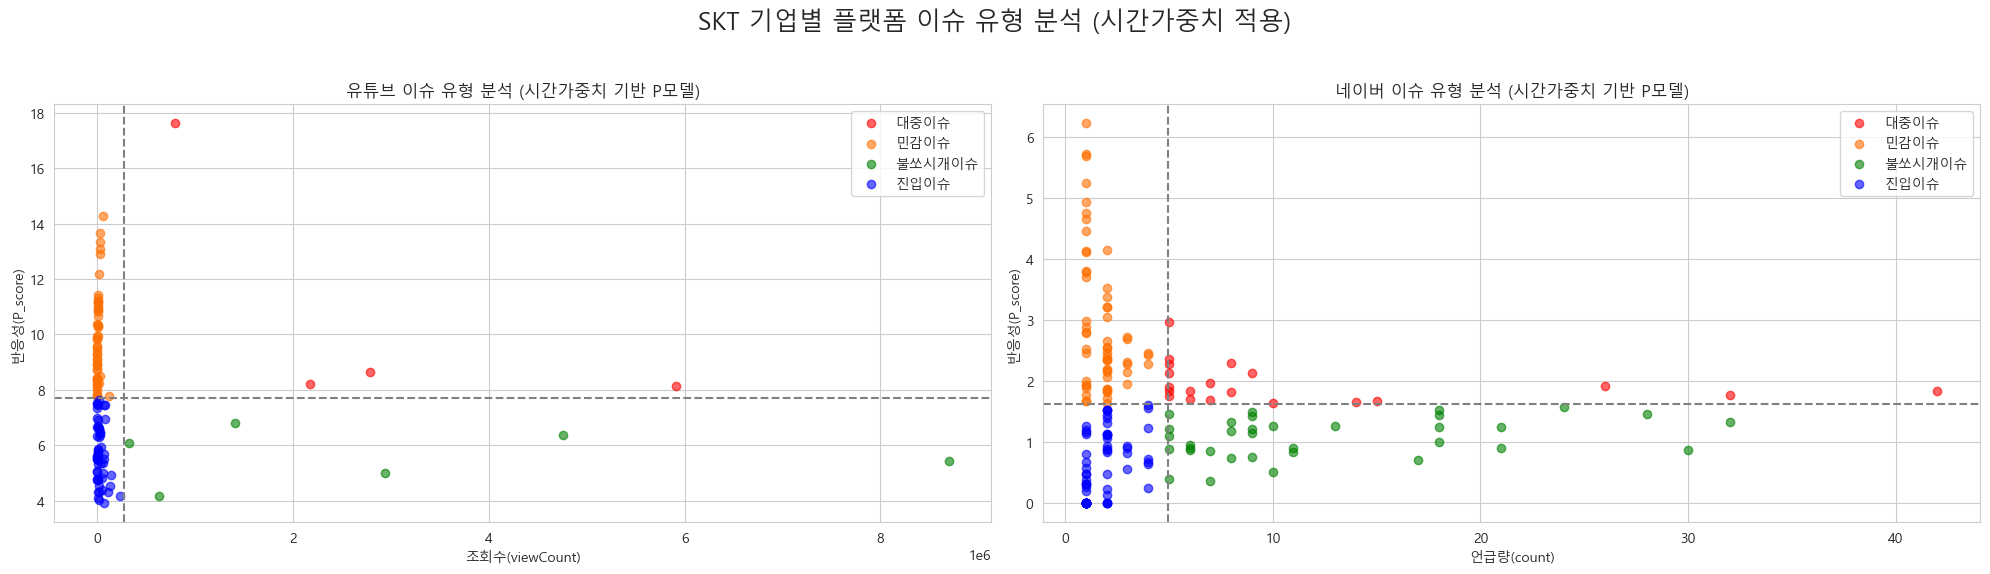

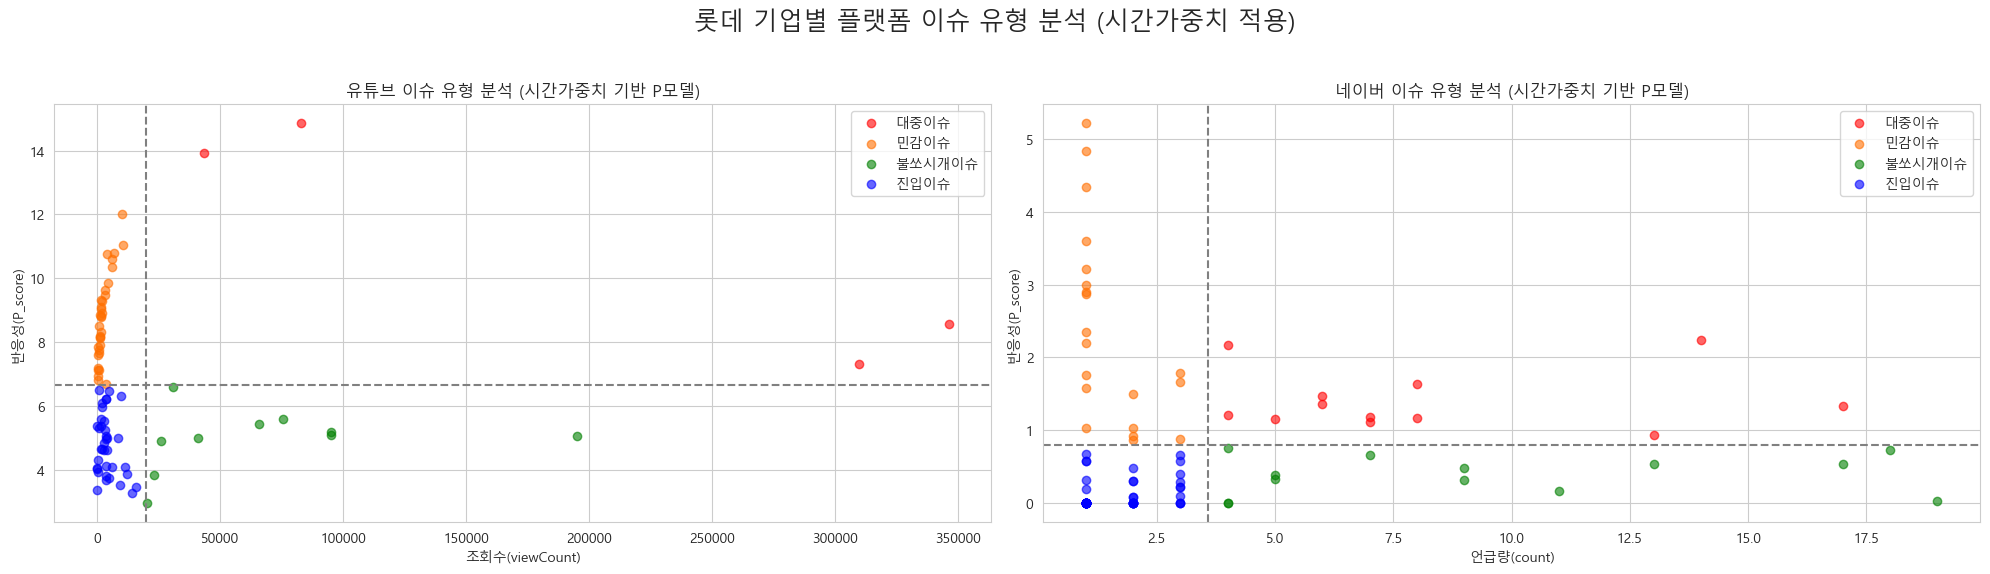

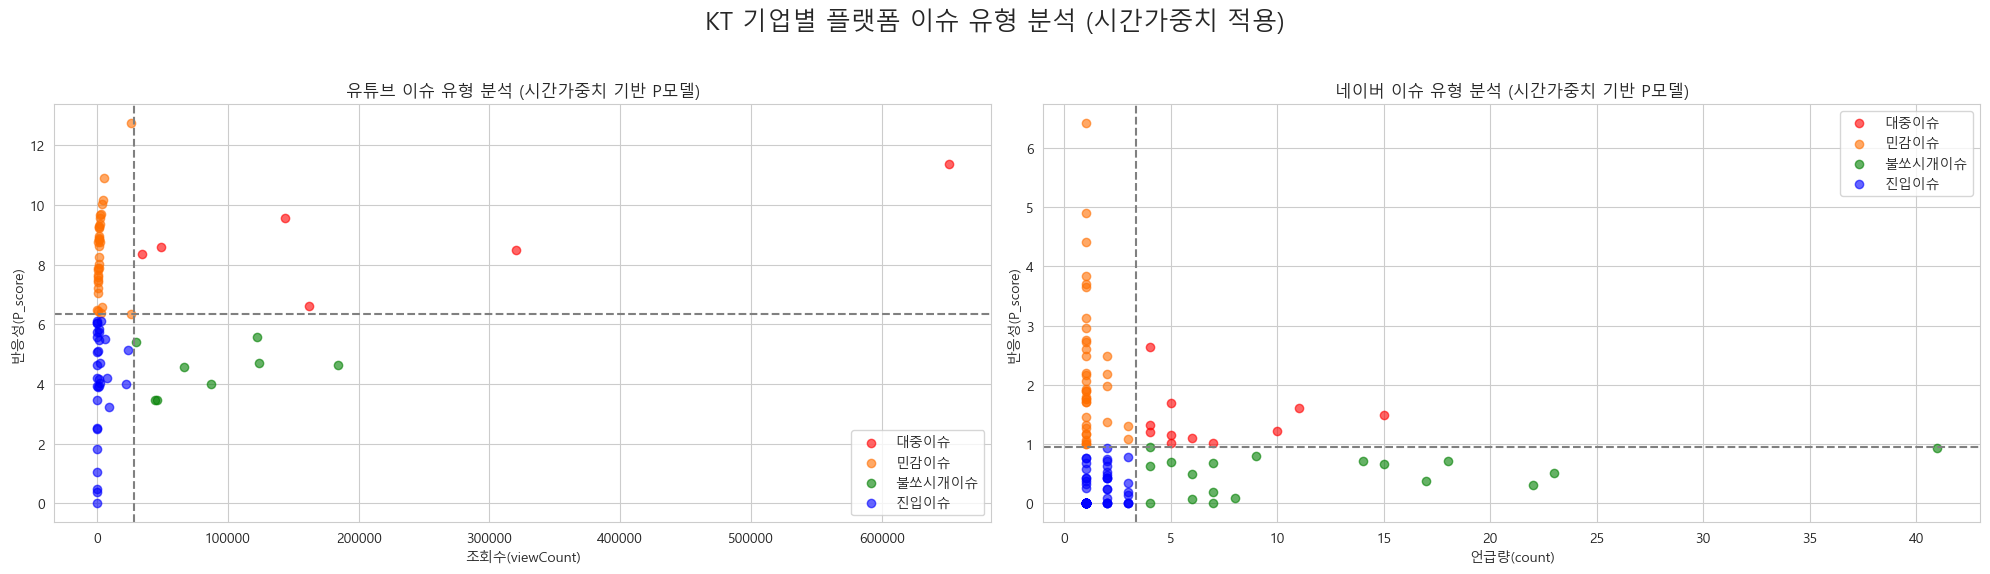

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import warnings

# --- ① 한글 폰트 경로 설정 ---
font_path = r"C:\Windows\Fonts\malgun.ttf"  # 또는 NanumGothic.ttf
font_name = fm.FontProperties(fname=font_path).get_name()

# --- ② matplotlib 전체에 한글 폰트 적용 ---
mpl.rcParams['font.family'] = font_name

# --- ③ 마이너스 기호 깨짐 방지 ---
mpl.rcParams['axes.unicode_minus'] = False

# --- ④ 글리프 경고 제거 ---
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# ===========================================
# 0) 한글 폰트 경고 제거
# ===========================================
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.family'] = 'Malgun Gothic'

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

# ===========================================
# 1) 시간 가중치 함수
# ===========================================
def compute_w(dt):
    h = dt.hour
    if 0 <= h < 3:   return 0.10
    if 3 <= h < 6:   return 0.15
    if 6 <= h < 9:   return 0.20
    if 9 <= h < 12:  return 0.25
    if 12 <= h < 15: return 0.30
    if 15 <= h < 18: return 0.25
    if 18 <= h < 21: return 0.40
    return 0.35   # 21~24


# ===========================================
# 2) 데이터 및 파일 경로 준비
# ===========================================
file_paths = [
    r"C:\Users\speec\OneDrive\Desktop\PoC_v2\GS_W.xlsx",
    r"C:\Users\speec\OneDrive\Desktop\PoC_v2\SKT_W.xlsx",
    r"C:\Users\speec\OneDrive\Desktop\PoC_v2\롯데_W.xlsx",
    r"C:\Users\speec\OneDrive\Desktop\PoC_v2\KT_W.xlsx"
]
company_names = ["GS", "SKT", "롯데", "KT"]


# ===========================================
# 3) P 지수 계산 함수
# ===========================================
def prepare_df(df):

    df = df.copy()
    df["m"] = df["count"].astype(float)     # 언급량

    # ----------------------------
    # 반응량 r
    # ----------------------------
    df["r"] = 0.0

    mask_youtube = df["channel"] == "유튜브"
    df.loc[mask_youtube, "r"] = (
        df.loc[mask_youtube, "viewCount"] +
        df.loc[mask_youtube, "likeCount"] +
        df.loc[mask_youtube, "comment_cnt"]
    )

    mask_naver = df["channel"] == "네이버"
    df.loc[mask_naver, "r"] = (
        df.loc[mask_naver, "comment_cnt"] +
        df.loc[mask_naver, "aligned_cnt_3h"]
    )

    # ----------------------------
    # 시간 가중치 w(dt)
    # ----------------------------
    df["datetime_3h"] = pd.to_datetime(df["datetime_3h"])
    df["w"] = df["datetime_3h"].apply(compute_w)

    # ----------------------------
    # 가중 반응량 r_adj = r × w
    # ----------------------------
    df["r_adj"] = df["r"] * df["w"]

    # ----------------------------
    # 최종 P score
    # ----------------------------
    df["P_score"] = np.log1p(df["r_adj"]) / np.log1p(df["m"])

    return df


# ===========================================
# 4) 플랫폼별 기준선 설정 + 시각화
# ===========================================
def draw_platform_scatter(ax, platform_name, data):

    if platform_name == "유튜브":
        x_col = "viewCount"
        xlabel = "조회수(viewCount)"
        x_thresh = data[x_col].mean()
    else:
        x_col = "m"
        xlabel = "언급량(count)"
        x_thresh = data[x_col].mean()

    y_col = "P_score"
    y_thresh = data[y_col].mean()

    # 사분면 색상
    color_map = {
        "대중이슈": "red",
        "민감이슈": "#FF6F00",   # 찐 주황색
        "불쏘시개이슈": "green",
        "진입이슈": "blue"
    }

    # 이슈 유형 분류
    def classify(row):
        x_val, y_val = row[x_col], row[y_col]
        if x_val >= x_thresh and y_val >= y_thresh:
            return "대중이슈"
        elif x_val < x_thresh and y_val >= y_thresh:
            return "민감이슈"
        elif x_val >= x_thresh and y_val < y_thresh:
            return "불쏘시개이슈"
        else:
            return "진입이슈"

    data = data.copy()
    data["issue_type"] = data.apply(classify, axis=1)

    # 시각화
    for issue, group in data.groupby("issue_type"):
        ax.scatter(group[x_col], group[y_col],
                   color=color_map[issue], alpha=0.6, label=issue)

    ax.axvline(x_thresh, linestyle="--", color="gray")
    ax.axhline(y_thresh, linestyle="--", color="gray")

    ax.set_title(f"{platform_name} 이슈 유형 분석 (시간가중치 기반 P모델)")
    ax.set_xlabel(xlabel)
    ax.set_ylabel("반응성(P_score)")
    ax.legend()
    ax.grid(True)


# ===========================================
# 5) 기업별 시각화 실행
# ===========================================
for file_path, company in zip(file_paths, company_names):

    df_company = pd.read_excel(file_path)
    df_company = prepare_df(df_company)

    youtube_df = df_company[df_company["channel"] == "유튜브"]
    naver_df = df_company[df_company["channel"] == "네이버"]

    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    plt.suptitle(f"{company} 기업별 플랫폼 이슈 유형 분석 (시간가중치 적용)", fontsize=18)

    draw_platform_scatter(axes[0], "유튜브", youtube_df)
    draw_platform_scatter(axes[1], "네이버", naver_df)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


▶ GS 처리 완료


C:\Users\speec\AppData\Local\Temp\ipykernel_17412\707706992.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


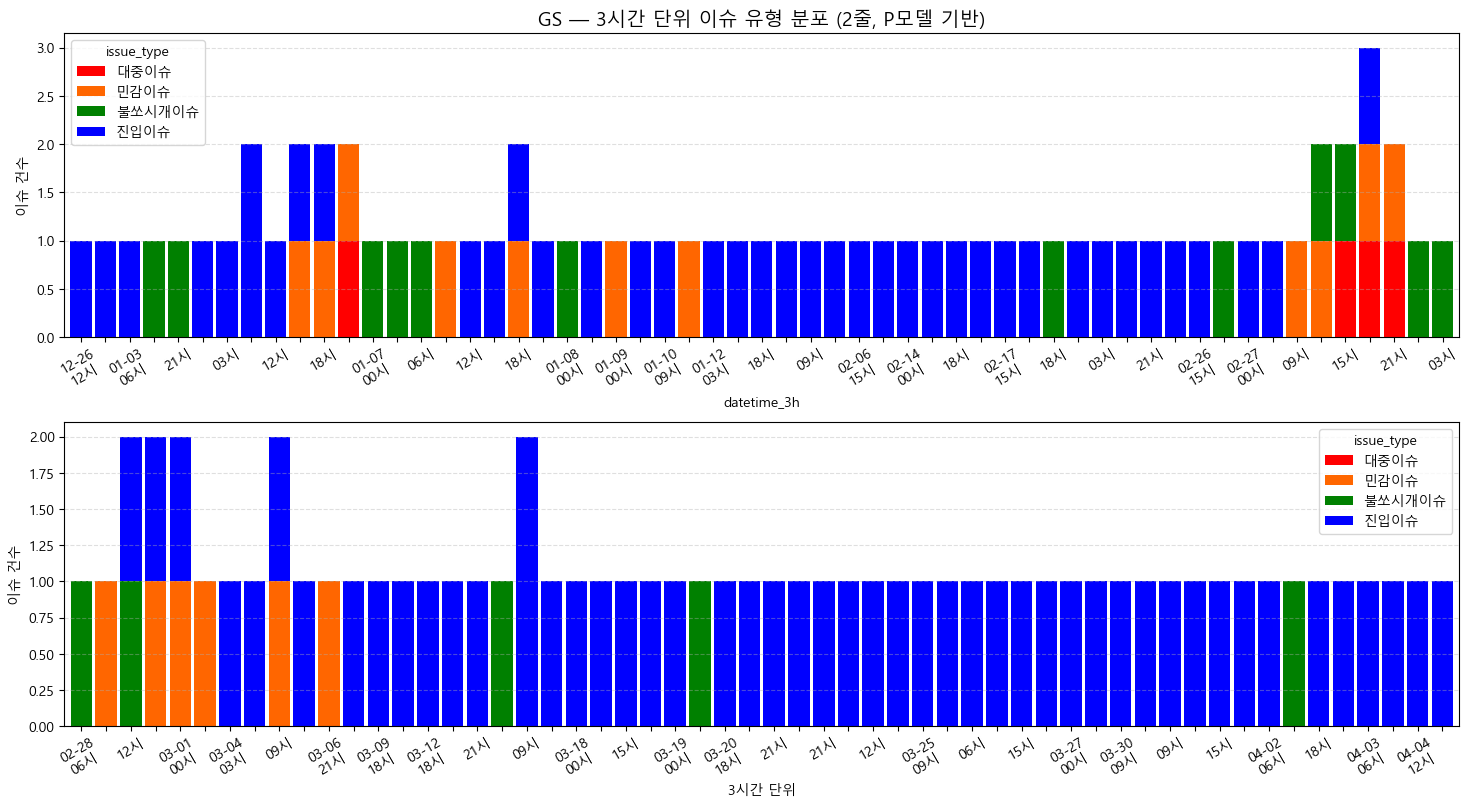

▶ GS 저장 완료: C:\Users\speec\OneDrive\Desktop\PoC_v2\GS_W_with_P.xlsx
▶ SKT 처리 완료


C:\Users\speec\AppData\Local\Temp\ipykernel_17412\707706992.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


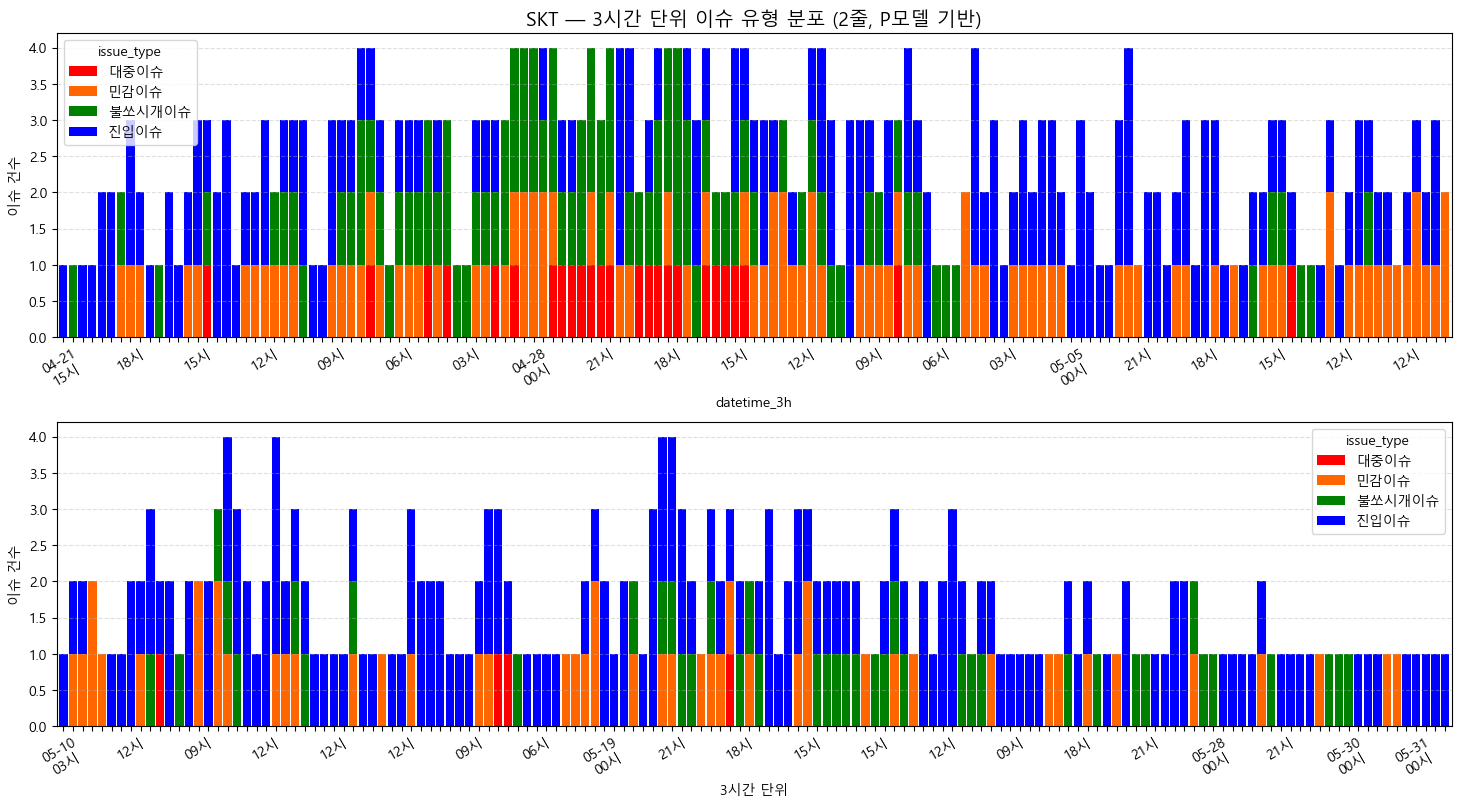

▶ SKT 저장 완료: C:\Users\speec\OneDrive\Desktop\PoC_v2\SKT_W_with_P.xlsx
▶ 롯데 처리 완료


C:\Users\speec\AppData\Local\Temp\ipykernel_17412\707706992.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


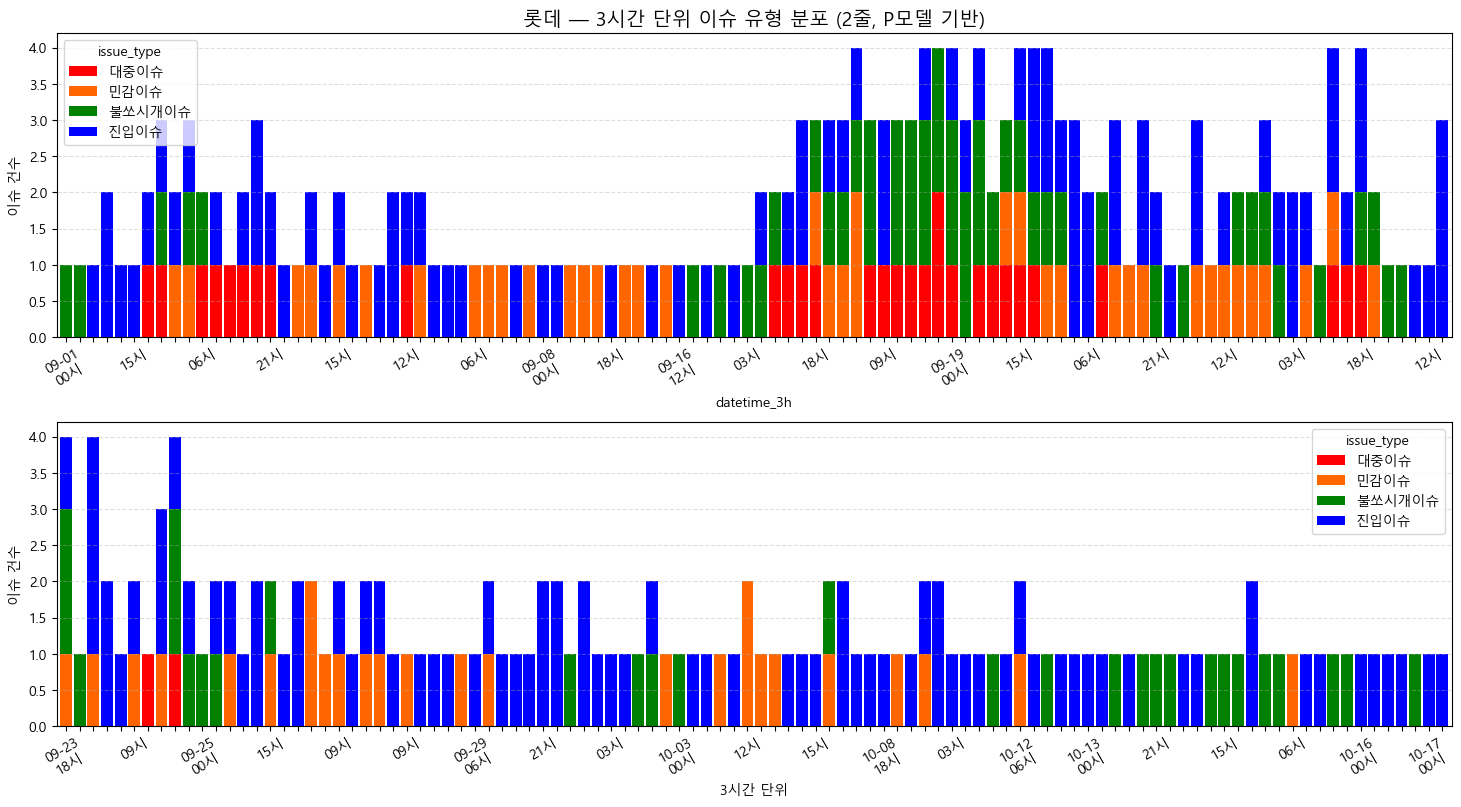

▶ 롯데 저장 완료: C:\Users\speec\OneDrive\Desktop\PoC_v2\롯데_W_with_P.xlsx
▶ KT 처리 완료


C:\Users\speec\AppData\Local\Temp\ipykernel_17412\707706992.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


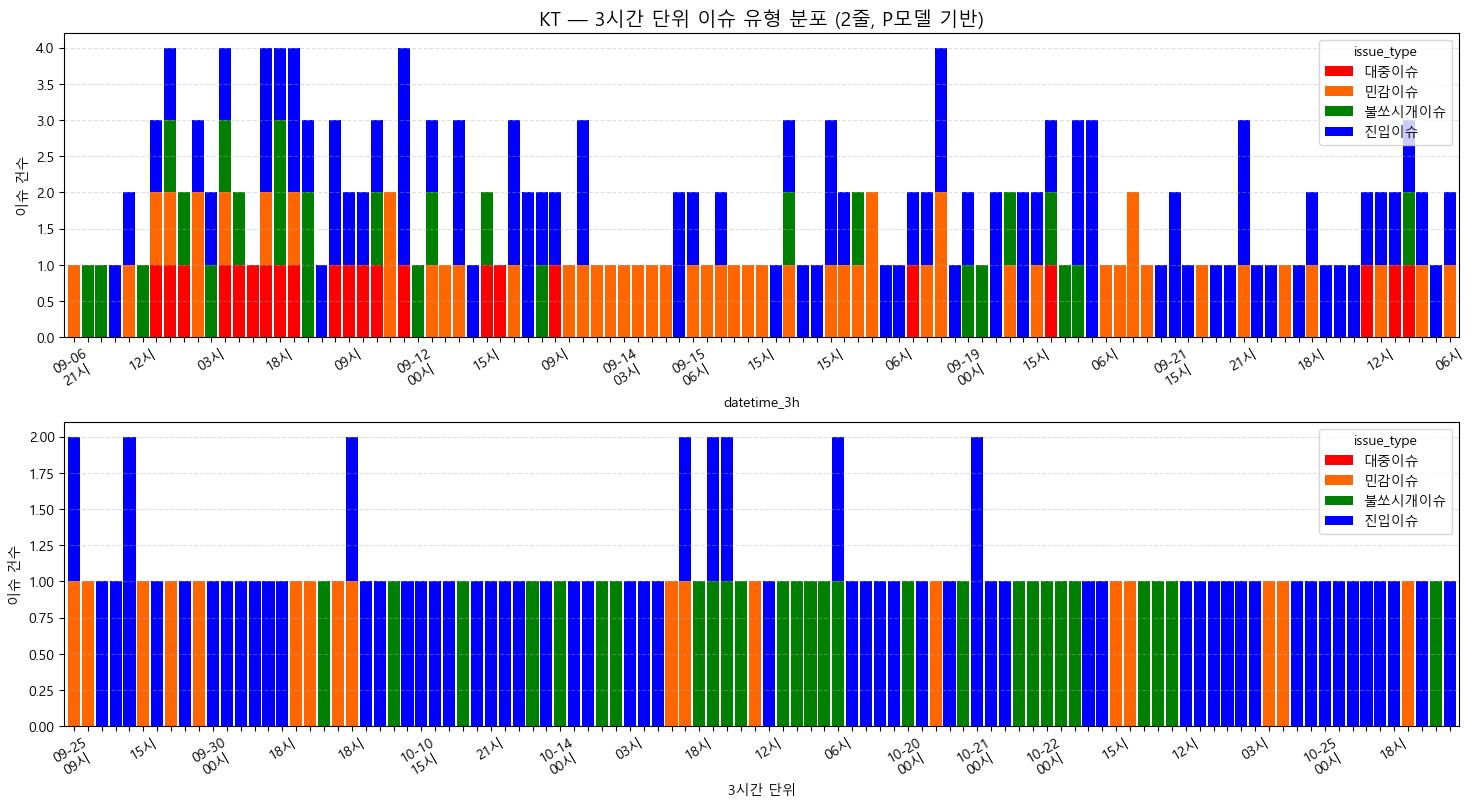

▶ KT 저장 완료: C:\Users\speec\OneDrive\Desktop\PoC_v2\KT_W_with_P.xlsx


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

# ===========================================
# 1) 시간 가중치 함수
# ===========================================
def compute_w(dt):
    h = dt.hour
    if 0 <= h < 3:   return 0.10
    if 3 <= h < 6:   return 0.15
    if 6 <= h < 9:   return 0.20
    if 9 <= h < 12:  return 0.25
    if 12 <= h < 15: return 0.30
    if 15 <= h < 18: return 0.25
    if 18 <= h < 21: return 0.40
    return 0.35

# ===========================================
# 2) 파일 목록
# ===========================================
file_paths = [
    r"C:\Users\speec\OneDrive\Desktop\PoC_v2\GS_W.xlsx",
    r"C:\Users\speec\OneDrive\Desktop\PoC_v2\SKT_W.xlsx",
    r"C:\Users\speec\OneDrive\Desktop\PoC_v2\롯데_W.xlsx",
    r"C:\Users\speec\OneDrive\Desktop\PoC_v2\KT_W.xlsx"
]
company_names = ["GS", "SKT", "롯데", "KT"]

# ===========================================
# 3) P 지수 계산
# ===========================================
def prepare_df(df):

    df = df.copy()
    df["m"] = df["count"].astype(float)

    # r 계산
    df["r"] = 0.0

    # 유튜브
    mask_y = df["channel"] == "유튜브"
    df.loc[mask_y, "r"] = (
        df.loc[mask_y, "viewCount"] +
        df.loc[mask_y, "likeCount"] +
        df.loc[mask_y, "comment_cnt"]
    )

    # 네이버
    mask_n = df["channel"] == "네이버"
    df.loc[mask_n, "r"] = (
        df.loc[mask_n, "comment_cnt"] +
        df.loc[mask_n, "aligned_cnt_3h"]
    )

    # 시간 가중치 적용
    df["datetime_3h"] = pd.to_datetime(df["datetime_3h"])
    df["w"] = df["datetime_3h"].apply(compute_w)

    df["r_adj"] = df["r"] * df["w"]
    df["P_score"] = np.log1p(df["r_adj"]) / np.log1p(df["m"])

    return df

# ===========================================
# 4) 분류 기준
# ===========================================
def classify_issue_types(df):

    df = df.copy()

    x_thresh = df["m"].mean()
    y_thresh = df["P_score"].mean()

    def classify(row):
        if row["m"] >= x_thresh and row["P_score"] >= y_thresh:
            return "대중이슈"
        elif row["m"] < x_thresh and row["P_score"] >= y_thresh:
            return "민감이슈"
        elif row["m"] >= x_thresh and row["P_score"] < y_thresh:
            return "불쏘시개이슈"
        else:
            return "진입이슈"

    df["issue_type"] = df.apply(classify, axis=1)
    return df

# ===========================================
# 5) 누적 막대그래프 함수
# ===========================================
def draw_stacked_bar_2rows(df, company):
    """
    한 기업 내 이슈 분포 누적막대그래프를 2줄(2xN/2)로 나누어 시각화,
    X축 라벨 겹침 완화.
    """
    pivot = (
        df.groupby(["datetime_3h", "issue_type"])
          .size()
          .unstack(fill_value=0)
    )
    # min/max 날짜 확인
    date_index = pd.to_datetime(pivot.index)
    total = len(pivot)
    # 2줄로 쪼개기(ceil 분할)
    n = total
    n1 = n // 2 + (n % 2)  # 상단
    n2 = n - n1            # 하단

    pivots = [pivot.iloc[:n1], pivot.iloc[n1:]]
    indices = [pivot.index[:n1], pivot.index[n1:]]

    colors = {
        "대중이슈": "red",
        "민감이슈": "#FF6600",
        "불쏘시개이슈": "green",
        "진입이슈": "blue"
    }

    fig, axs = plt.subplots(
        2, 1,
        figsize=(18, min(9, 3*(n1//12+1)+3*(n2//12+1))),
        sharex=False,
        gridspec_kw=dict(hspace=0.28)
    )

    for i, (ax, piv, idx) in enumerate(zip(axs, pivots, indices)):
        piv.plot(
            kind="bar",
            stacked=True,
            color=[colors.get(c, "grey") for c in piv.columns],
            ax=ax,
            width=0.87
        )
        labels = []
        prev_day = None
        for dt in idx:
            day_str = dt.strftime("%m-%d")
            time_str = dt.strftime("%H시")
            # 날짜 바뀔 때줄띄움(오전에만 날짜 표기)
            if (prev_day is None) or (day_str != prev_day):
                labels.append(f"{day_str}\n{time_str}")
                prev_day = day_str
            else:
                labels.append(time_str)
        # 라벨 간격(많으면 일부만 표시)
        xtick_loc = ax.get_xticks()
        if len(labels) > 20:
            skip = max(1, len(labels)//20)
            for j in range(len(labels)):
                if j % skip != 0:
                    labels[j] = ""
        ax.set_xticklabels(labels, rotation=0 if len(labels)<=13 else 30, fontsize=10, ha="center")
        ax.set_ylabel("이슈 건수")
        ax.grid(axis="y", linestyle="--", alpha=0.4)
        if i == 0:
            ax.set_title(f"{company} — 3시간 단위 이슈 유형 분포 (2줄, P모델 기반)", fontsize=14)

    axs[1].set_xlabel("3시간 단위")
    plt.tight_layout()
    plt.show()


# ===========================================
# 6) 전체 파일 반복 실행
# ===========================================
for file_path, company in zip(file_paths, company_names):

    df_company = pd.read_excel(file_path)
    df_company = prepare_df(df_company)
    df_company = classify_issue_types(df_company)

    print(f"▶ {company} 처리 완료")

    draw_stacked_bar_2rows(df_company, company)

    # ===============================
    # 추가: 결과 저장 (P/P_norm/이슈유형별 count)
    # ===============================

    # P 컬럼: P_score
    df_company["P"] = df_company["P_score"]

    # P_norm 컬럼: 0~1 scaling
    P_min = df_company["P_score"].min()
    P_max = df_company["P_score"].max()
    if P_max > P_min:
        df_company["P_norm"] = (df_company["P_score"] - P_min) / (P_max - P_min)
    else:
        df_company["P_norm"] = 0.0

    # 이슈유형별 컬럼(count)
    issue_types = ["불쏘시개이슈", "민감이슈", "대중이슈", "진입이슈"]
    for issue in issue_types:
        # 각 row가 해당 이슈유형이면 1, 아니면 0
        df_company[issue] = (df_company["issue_type"] == issue).astype(int)

    # 컬럼 순서: 기존 + ["P", "P_norm", 각 이슈유형]
    extra_cols = ["P", "P_norm"] + issue_types
    cols = list(df_company.columns)
    # 순서 되도록 보장
    for ec in extra_cols:
        if ec in cols:
            cols.remove(ec)
    cols += extra_cols
    df_company = df_company[cols]

    # 원본 경로에 "_with_P" 붙여 저장 (확장자 직전)
    base, ext = os.path.splitext(file_path)
    out_path = base + "_with_P" + ext

    df_company.to_excel(out_path, index=False)
    print(f"▶ {company} 저장 완료: {out_path}")



In [51]:
!pip install koreanize-matplotlib

In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import warnings

# --- 폰트 강제 등록 ---
font_path = r"C:\Windows\Fonts\malgun.ttf"
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)

mpl.rcParams['font.family'] = font_prop.get_name()
mpl.rcParams['axes.unicode_minus'] = False

warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


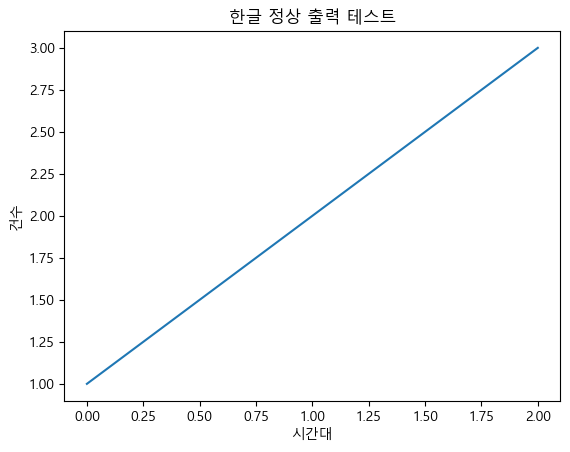

In [2]:
plt.plot([1,2,3])
plt.title("한글 정상 출력 테스트")
plt.xlabel("시간대")
plt.ylabel("건수")
plt.show()


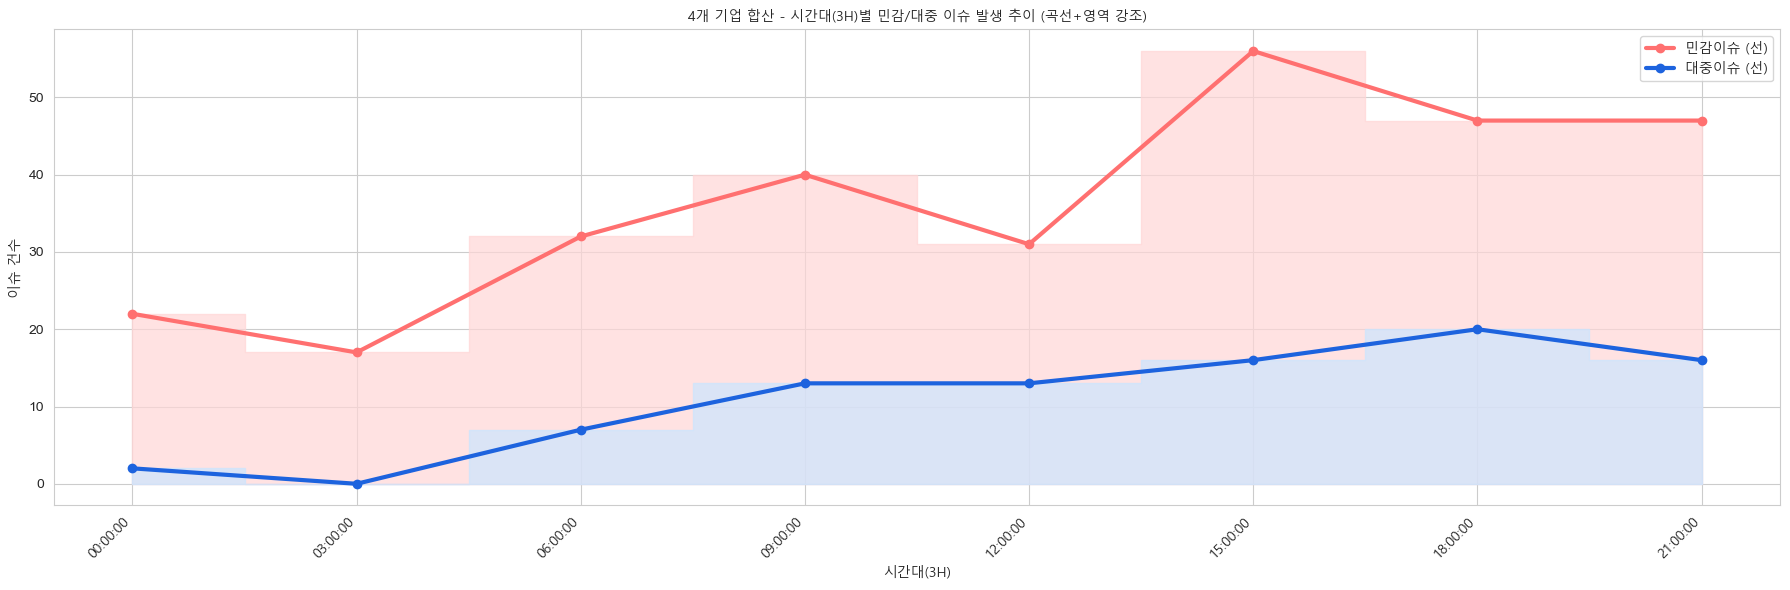

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.font_manager as fm
import warnings
import os

# --- 폰트 강제 등록: 한글 타이틀/레이블 깨짐 방지 ---
font_path = r"C:\Windows\Fonts\malgun.ttf"
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = font_prop.get_name()
mpl.rcParams['axes.unicode_minus'] = False

warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# 1) 파일 경로 (4개 기업)
file_paths = [
    r"C:\Users\speec\OneDrive\Desktop\PoC_v2\GS_W_with_P.xlsx",
    r"C:\Users\speec\OneDrive\Desktop\PoC_v2\SKT_W_with_P.xlsx",
    r"C:\Users\speec\OneDrive\Desktop\PoC_v2\롯데_W_with_P.xlsx",
    r"C:\Users\speec\OneDrive\Desktop\PoC_v2\KT_W_with_P.xlsx"
]

# 2) 모든 기업 데이터 합치기
dfs = []
for file_path in file_paths:
    df = pd.read_excel(file_path)
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)

# 3) 'datetime_3h'가 문자열/날짜형 아닌 경우 처리
df_all["datetime_3h"] = pd.to_datetime(df_all["datetime_3h"], errors="coerce")
df_all["시간대(3H)"] = df_all["datetime_3h"].dt.time.astype(str)

# 4) '민감이슈'와 '대중이슈'만 따로 집계
issue_types_to_count = ["민감이슈", "대중이슈"]
result = {}
for issue_type in issue_types_to_count:
    filtered = df_all[df_all["issue_type"] == issue_type]
    time_counts = filtered["시간대(3H)"].value_counts().sort_index()
    time_counts = time_counts.rename_axis("시간대(3H)").reset_index(name=f"{issue_type}_건수")
    result[issue_type] = time_counts

# 시간대(3H) 기준 merge (outer join, 결측치는 0)
all_times = sorted(df_all["시간대(3H)"].unique())
df_merged = pd.DataFrame({"시간대(3H)": all_times})
for issue_type in issue_types_to_count:
    df_merged = df_merged.merge(result[issue_type], how="left", on="시간대(3H)")
df_merged = df_merged.fillna(0)

# 5) 시각화 (첫번째만)
plt.figure(figsize=(18,6))
x = np.arange(len(df_merged["시간대(3H)"]))

sns.set_style("whitegrid")
plt.plot(x, df_merged["민감이슈_건수"], marker='o', color="#ff7070", label="민감이슈 (선)", linewidth=3)
plt.fill_between(x, df_merged["민감이슈_건수"], color="#ffd6d6", alpha=0.7, step='mid')

plt.plot(x, df_merged["대중이슈_건수"], marker='o', color="#1d63de", label="대중이슈 (선)", linewidth=3)
plt.fill_between(x, df_merged["대중이슈_건수"], color="#cbe5ff", alpha=0.7, step='mid')

plt.title("4개 기업 합산 - 시간대(3H)별 민감/대중 이슈 발생 추이 (곡선+영역 강조)", 
          fontsize=18, weight='bold', fontproperties=font_prop)
plt.xlabel("시간대(3H)", fontproperties=font_prop)
plt.ylabel("이슈 건수", fontproperties=font_prop)
plt.xticks(x, df_merged["시간대(3H)"], rotation=45, ha='right', fontproperties=font_prop)
plt.legend(prop=font_prop)
plt.tight_layout()
plt.show()


In [56]:
import matplotlib as mpl
mpl.get_cachedir()

'C:\\Users\\speec\\.matplotlib'